<a href="https://colab.research.google.com/github/andygoosh/samsung/blob/master/workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
from pathlib import Path
from google.colab import files, drive
from collections import defaultdict

import re
import random as rn
import pandas as pd
import numpy as np
from numpy import array, argmax, random, take
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Input, Dropout, Dense, LSTM, GRU, Embedding, RepeatVector, Lambda, TimeDistributed
from keras.layers import Bidirectional as Bi
from keras import optimizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

RS = 77
rn.seed(RS)
# tf.random.set_seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)

gpath = Path('/content/gdrive')
drive.mount(str(gpath))
data_file = gpath / 'My Drive/Samsung' / 'transcriptions'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### Let's look at the data in given file

In [127]:
with data_file.open() as f:  
    print(list(f.readline()))

['а', 'у', 'к', 'ц', 'и', 'о', 'н', 'ы', ' ', 'н', 'а', ' ', 'д', 'е', 'ш', 'ё', 'в', 'о', 'е', ' ', 'ж', 'и', 'л', 'ь', 'ё', ' ', 'п', 'р', 'о', 'в', 'о', 'д', 'я', 'т', 'с', 'я', ' ', 'р', 'е', 'г', 'у', 'л', 'я', 'р', 'н', 'о', '\t', '%', '%', ' ', 'a', ' ', 'u', ' ', 'k', ' ', 't', 's', ' ', 'y', ' ', 'o', '1', ' ', 'n', ' ', 'a', 'x', ' ', '#', ' ', 'n', ' ', 'a', 'x', "'", ' ', '_', ' ', 'd', "'", ' ', "'", 'i', ' ', 's', 'h', ' ', 'o', '1', ' ', 'v', ' ', 'a', 'x', "'", ' ', 'j', 'a', 'x', ' ', '#', ' ', 'z', 'h', ' ', 'y', "'", ' ', 'l', "'", ' ', 'j', "'", ' ', "'", 'o', '1', ' ', '#', ' ', 'p', ' ', 'r', ' ', 'a', ' ', 'v', ' ', 'o', "'", '1', ' ', 'd', "'", ' ', "'", 'a', 'x', ' ', 't', 's', ' ', 't', 's', ' ', 'a', 'x', "'", ' ', '#', ' ', 'r', "'", ' ', "'", 'i', 'x', ' ', 'g', ' ', 'u', "'", ' ', 'l', "'", ' ', "'", 'a', '1', ' ', 'r', ' ', 'n', ' ', 'a', ' ', '%', '%', '\n']


#### Notice that:
1. russian sentence is separated from transcript with '\t'
2. the begining and the end of transcript part are marked by '%%'

### Let's read the data and split it into rus and trans

In [128]:
rus_trn = []
with data_file.open() as f:  
  for line in f: 
    rus, trn = line.split('\t')
    rus_trn.append([rus.strip(), trn.strip()])

print(f'Number of sentences in corpus: {len(rus_trn)}')

Number of sentences in corpus: 50277


##### Let's look at some sentences


In [129]:
a,b,c = np.random.choice(len(rus_trn), 3)

print(rus_trn[a][0])
print(rus_trn[a][1])
print(rus_trn[b][0])
print(rus_trn[b][1])
print(rus_trn[c][0])
print(rus_trn[c][1])

веб-операторы обязаны ознакомить пользователя с политикой по сбору персональной информации
%% v' 'e1 p a' p' 'i r a1 t ax r ax # a' b' 'a1 z ax n ax # a z n a k o'1 m' 'ix' t' # p o'1 l' z ax v ax' t' 'ix' l' 'ax # s _ p a' l' 'i'1 t' 'ix k ax' j' # p a _ z b o1 r ux' # p' 'ix r s a n a'1 l' n ax' j' # 'i n f a r m a1 ts ax' i %%
цена мартовского контракта на нефть в торговой системе поднялась
%% ts y n a1 # m a1 r t ax f s k ax v ax # k a n t r a1 k t ax # n a' _ n' 'e1 f t' # f _ t a r g o1 v ax' j' # s' 'i' s' t' 'e'1 m' 'ix # p ax' d' n' 'i l a'1 s' %%
в августе прошлого года был достроен храм христа спасителя
%% v _ a1 v g ux' s' t' 'ix # p r o1 sh l ax v ax # g o1 d ax # b y1 l # d a s t r o'1 jax n # h r a1 m # h r' 'i s t a1 # s p a' s' 'i'1 t' 'ix' l' 'a %%


#### Notice that words in russian sentence are separated by space while words in transcript are separated:
1. by '#' in general case
2. by '_' in case of preposition
3. by '%% %%' in case of punctuation signs (dash, coma, etc)


#### Let's see if we have dupliates in corpus

In [130]:
a = array(rus_trn)
seen_rus = Counter(a[:,0])
seen_trn = Counter(a[:,1])

print(f'Unique rus sentences: {len(seen_rus)} out of {len(rus_trn)}')
print(f'Unique trans sentences: {len(seen_trn)} out of {len(rus_trn)}')

Unique rus sentences: 3131 out of 50277
Unique trans sentences: 3171 out of 50277


#### We have a lot of duplicates! Only 3131 unique sentenses out of 50K in corpus. Please also note that some russian sentences are transcribed into different transcriptions (will look into that later on)

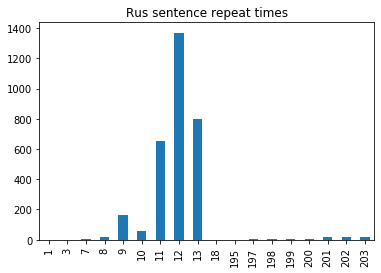

In [131]:
lens = [each[1] for each in seen_rus.items()]
unq = np.unique(lens)
qty = [lens.count(each) for each in unq]
pd.DataFrame(qty, index=unq).plot.bar(title = 'Rus sentence repeat times', legend=False);

#### Most duplicated sentences repeat 12 times, max up to 203 times

### Let's read that data while splitting the tokens. We'll count the tokens in each sentence. If the count in rus and trans is different, we'll record it as anomaly


Anomalies: 49


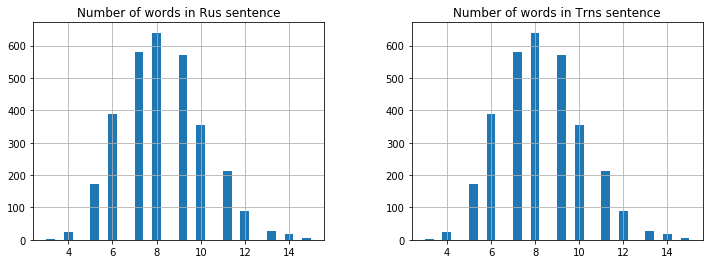

In [132]:
rus_l, trn_l, anomaly = [], [], []
seen = defaultdict(list)
chars = Counter()

for j,i in enumerate(rus_trn):
  rus = i[0].split()
  trn = re.split('#|_|%% %%',i[1])

  if i[0] not in seen:
    if abs(len(rus) - len(trn)) != 0: 
      anomaly.append(j)
      # print(j, ' ', i[0])
      # print( i[1])
    
    else:
      rus_l.append(len(rus))
      trn_l.append(len(trn))

    chars += Counter(i[0])

  seen[i[0]].append(j)

print(f'Anomalies: {len(anomaly)}')
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
pd.DataFrame({'Number of words in Rus sentence':rus_l}).hist(ax=ax1, bins = 30);
pd.DataFrame({'Number of words in Trns sentence':trn_l}).hist(ax=ax2, bins = 30);

#### So we have 49 anomalies out of 3131 samples

### Let's see if we need to clean the data. First let's take a look at rus corpus alphabet

Number of times "-" used: 159


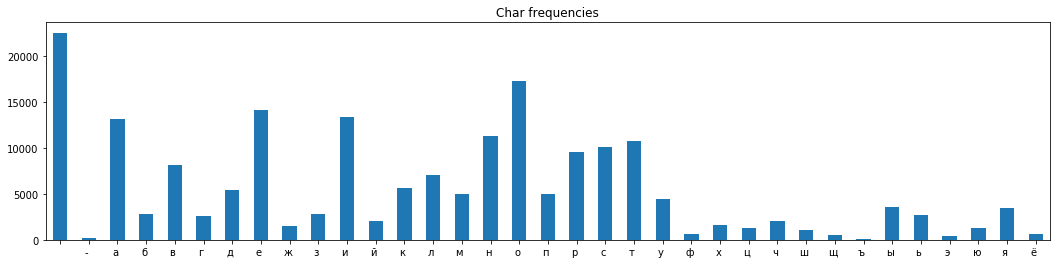

In [133]:
s = sorted(chars.items())
pd.DataFrame(s, index=(e[0]+' ' for e in s)).plot.bar(figsize=(18,4), rot=0, title = 'Char frequencies', legend=False)
print(f'Number of times "-" used: {chars["-"]}')

#### Looks good! We neither have punctuations nor capital letters. The only case to check is '-' letter which is used 159 times

In [134]:
seen = set()
seen_dash = set()
dash_words = []
for rus,trn in rus_trn:
  if rus not in seen:
    if '-' in rus:
      ru_words = rus.split()
      for each in ru_words:
        if '-' in each:
          if each not in seen_dash:
            seen_dash.add(each)
            dash_words.append(each)
  else:
    seen.add(rus)
  
print(dash_words)

['анти-обледенитель', 'иридо-диагностика', 'дом-красавец', 'из-за', 'радио-сигналом', 'ноль-три', 'ноль-два', 'мало-обеспеченные', 'шкаф-купе', 'тех-осмотр', 'пресс-службе', 'авто-сервис', 'чуть-чуть', 'аудио-', 'какие-либо', 'де-факто', 'стерео-', 'царь-колокол', 'царь-пушка', 'гео-магнитного', 'электро-катастрофы', 'фигуристы-новобранцы', 'что-то', 'какое-либо', 'веб-операторы', 'воздушно-десантной', 'военно-морских', 'ветераны-афганцы', 'одного-единственного', 'природно-климатические', 'одном-двух', 'санкт-петербурге', 'стран-участниц', 'пять-шесть', 'по-своему', 'матч-реванш', 'словаря-справочника', 'штаб-квартире', 'чем-то', 'чего-то', 'экс-губернатора', 'российско-американский', 'северо-восточных', 'красно-белую', 'какой-нибудь', 'бело-жёлтый', 'карту-схему', 'юго-западный', 'радио-охранное', 'по-прежнему', 'каким-то', 'кино-картины', 'авто-трюки', 'пресс-конференции', 'генерал-прокурором', 'нью-йорке', 'медиа-группы', 'нью-йоркской', 'какие-то', 'санкт-петербурга', 'санкт-петерб

#### Okey, words with dash look fine, we'll consider dash as a normal letter

### The size of the corpus is too small to tokenize on words. Insted we'll tokenize bsed on characters

### So in order to implement autocoder for transcript we'd need to keep special symbools in transcript such as "\_" and "%% %%". So let's create a dictionary of sentences rus <-> trans. So let's recreate the dictionary so "\_" and "%% %%" are marked with '#' and remove begin and end markers. Plus to that let's get rid of duplicates.


max len rus: 27, max len trn: 26


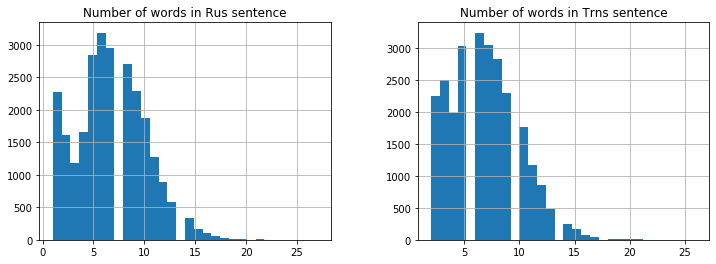

In [135]:
seen_rus = set()
seen_trn = set()

res, trn_l, rus_l = [], [], []
for rus, trn in rus_trn:

  if rus not in seen_rus or trn not in seen_trn:
      seen_rus.add(rus)
      seen_trn.add(trn)

      # trn = trn.replace('%% %%', '%% %% #').replace('_', '_ #')[3:-3]
      # trn = trn.split(' ')
      # rus_l.append( len(rus))
      # trn_l.append( len(trn))
      # res.append([list(rus), trn, trn])

      # trn = trn.replace('%% %%', '#').replace('_', '#')[3:-3]
      trn = trn.replace('%% %%', '# <PNK>').replace('_', '_ #')[3:-3]
      trn = trn.split('#')
      rus = rus.split(' ')
      for a,b in zip(rus, trn):
        b = b.strip().split(' ')
        # res.append((list(a), b + ['<eos>'], ['<sos>'] + b))
        res.append((list(a), b, b))
        rus_l.append( len(a))
        trn_l.append( len(b))


rus_trn_new = array(res)
trn_length = max(trn_l)
rus_length = max(rus_l)
print(f'max len rus: {rus_length}, max len trn: {trn_length}')
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
pd.DataFrame({'Number of words in Rus sentence':rus_l}).hist(ax=ax1, bins = 30);
pd.DataFrame({'Number of words in Trns sentence':trn_l}).hist(ax=ax2, bins = 30);

In [136]:
a = np.random.choice(len(rus_trn_new))
rus_trn_new[a]

array([list(['н', 'а']), list(['n', "a'", '_']), list(['n', "a'", '_'])],
      dtype=object)

### Text to Sequence Conversion

In [137]:
def tokenization(lines, split=' '):
  tokenizer = Tokenizer(filters='', lower=False, split=split)
  tokenizer.fit_on_texts(lines)
  return tokenizer

def encode_sequences(tokenizer, length, lines):
  seq = tokenizer.texts_to_sequences(lines)
  seq = pad_sequences(sequences=seq, maxlen=length, padding='post')
  return seq

rus_tokenizer = tokenization(rus_trn_new[:, 0], split='')
rus_vocab_size = len(rus_tokenizer.word_index) + 1
# rus_trn_new[0, 1] +=  ['<sos>', '<eos>']
trn_tokenizer = tokenization(rus_trn_new[:, 1], split=' ')
trn_vocab_size = len(trn_tokenizer.word_index) + 1
print(f'Rus Vocabulary Size: {rus_vocab_size}')
print(f'Trns Vocabulary Size: {trn_vocab_size}')

Rus Vocabulary Size: 35
Trns Vocabulary Size: 116


### Model Building


In [139]:
def cbow(x, window_size=1):
  res = []
  for e in x:
    len_x = len(e)
    vec = []
    for i in range(len_x):
      bow = [0] * (window_size*2 + 1)
      first_context_word_index = max(0, i-window_size)
      last_context_word_index = min(i+window_size, len_x-1)
      for k,j in enumerate(range(first_context_word_index, last_context_word_index+1)):
        bow[k] = e[j]
    
      vec.append(bow)
    res.append(vec)
  return np.array(res)

train, test = train_test_split(rus_trn_new, test_size=0.1, random_state = RS)

# rus_length = trn_length = max(trn_length, rus_length)

# prepare training data
trainX = encode_sequences(rus_tokenizer, rus_length, train[:, 0])
# trainX = cbow(trainX)
trainX_ = encode_sequences(trn_tokenizer, trn_length, train[:, 2])
trainY = encode_sequences(trn_tokenizer, trn_length, train[:, 1])

# prepare validation data
testX = encode_sequences(rus_tokenizer, rus_length, test[:, 0])
# testX = cbow(testX)
testX_ = encode_sequences(trn_tokenizer, trn_length, test[:, 2])
testY = encode_sequences(trn_tokenizer, trn_length, test[:, 1])

a = np.random.choice(len(trainX))
print(a)
print( rus_tokenizer.sequences_to_texts([trainX[a]]) )
print( trn_tokenizer.sequences_to_texts([trainY[a]]) )
print( trn_tokenizer.sequences_to_texts([trainX_[a]]) )



4832
['д о р о г о']
['d o1 r ax g a']
['d o1 r ax g a']


Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_29 (Embedding)        (None, 27, 512)      17920       input_20[0][0]                   
__________________________________________________________________________________________________
lstm_44 (LSTM)                  [(None, 512), (None, 2099200     embedding_29[0][0]               
__________________________________________________________________________________________________
repeat_vector_16 (RepeatVector) (None, 26, 512)      0           lstm_44[0][0]                    
___________________________________________________________________________________________

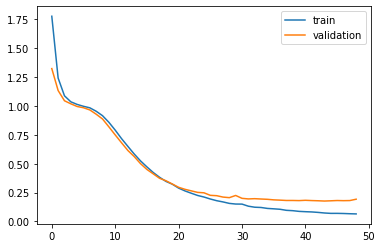

In [140]:
from keras import backend as K
EPOCHES = 100
BS = 512
window_size = 1
TF = False

def define_model_lstm(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  cbow = Sequential()
  cbow.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
  cbow.add(LSTM(units, return_sequences=True))
  cbow.add(Dense(in_vocab, activation='softmax'))
  return cbow, None, None

# build NMT model
def define_model_cbow(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  input = x = Input(shape=(None,))
  x = Embedding(in_vocab, 100, input_length=window_size*2+1, mask_zero=True)(x)
  x = Lambda(lambda x: K.mean(x, axis=2))(x)
  output = Dense(out_vocab, activation='softmax')(x)
  model = Model(input, output)
  return model, None, None

# build NMT model
def define_model_simple(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  input = x = Input(shape=(None,))
  x = Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)(x)
  x, h, c = LSTM(units, return_state=True)(x)
  x = RepeatVector(out_timesteps)(x)
  x = LSTM(units, return_sequences=True)(x, initial_state = (h, c))
  output = Dense(out_vocab, activation='softmax')(x)
  model = Model(input, output)
  return model, None, None

def define_model_tf(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
   # encoder
  encoder_inputs = Input(shape=(None,))
  encoder_embedding = Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)
  encoder = encoder_embedding(encoder_inputs)
  _, state_h, state_c = LSTM(units, return_state=True)(encoder)
  encoder_states = [state_h, state_c]
  # decoder
  decoder_inputs = Input(shape=(None,))
  decoder_embedding = Embedding(out_vocab, units, input_length=out_timesteps, mask_zero=True)
  decoder = decoder_embedding(decoder_inputs)
  decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
  decoder_outputs, _, _ = decoder_lstm(decoder, initial_state=encoder_states)
  decoder_dense = Dense(out_vocab, activation='softmax')
  decoder_outputs = decoder_dense(decoder_outputs)
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  #inference model
  encoder_model = Model(encoder_inputs, encoder_states)

  decoder_state_input_h = Input(shape=(units,))
  decoder_state_input_c = Input(shape=(units,))
  decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
  decoder_outputs, h, c = decoder_lstm(decoder, initial_state=decoder_states_inputs)
  decoder_states = [h, c]
  decoder_outputs = decoder_dense(decoder_outputs)
  decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
  
  return model, encoder_model, decoder_model

define_model = define_model_tf if TF else define_model_simple

model, encoder_model, decoder_model = define_model(rus_vocab_size, trn_vocab_size, rus_length, trn_length, 512)
model.summary()
  
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

monitor = 'val_loss'
mode = 'min'
early_stop = EarlyStopping( patience=5, monitor=monitor, mode=mode, restore_best_weights=True)

if TF:
  data = [trainX, trainX_], trainY.reshape(*trainY.shape, 1)
  validation_data = [testX, testX_], testY.reshape(*testY.shape, 1)
else:
  data = trainX, trainY.reshape(*trainY.shape, 1)
  validation_data = testX, testY.reshape(*testY.shape, 1)

history = model.fit(*data, 
          epochs=EPOCHES, batch_size=BS, 
          validation_data=validation_data,
          callbacks=[early_stop], verbose=1)

# plot validation loss vs training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [141]:
def translate_sentence(input_seq):
  states_value = encoder_model.predict(input_seq, use_multiprocessing=True)
  target_seq = np.array([0] * trn_length)
  target_seq[0] = trn_tokenizer.word_index['<sos>']
  eos = trn_tokenizer.word_index['<eos>']
  output_sentence = []

  for _ in range(trn_length):
      output_tokens, h, c = decoder_model.predict([target_seq.reshape(1, -1)] + states_value, use_multiprocessing=True)
      idx = np.argmax(output_tokens[0,0,:])
      # print(trn_tokenizer.index_word[idx])
      if eos == idx:
          break

      if idx > 0:
          word = trn_tokenizer.index_word[idx]
          output_sentence.append(word)

      target_seq[0] = idx
      states_value = [h, c]

  return ' '.join(output_sentence)

a = np.random.choice(len(testX), 15)

if TF:
  translation = []
  for i in a:
    input_seq = testX[i]
    translation.append( translate_sentence(input_seq) )
else:
  x = testX[a]
  pred_ohe = model.predict(x, use_multiprocessing=True)
  pred = np.argmax(pred_ohe, axis=2)
  translation = trn_tokenizer.sequences_to_texts(pred)

pred_df = pd.DataFrame({'actual' : trn_tokenizer.sequences_to_texts(testY[a]), 'predicted' : translation})
pred_df

,actual,predicted
0,f s t r' 'e'1 t' 'ix' d',f s t r' 'e'1 t' 'ix' t'
1,v _,v _
2,o1 p sh' 'ix s t v ax,o1 p sh' 'ix s t v ax
3,k _,k _
4,n ax _,n ax _
5,p' 'ix' r' 'ix h a' d' 'i'1 t',p' 'ix' r' 'ix h a' d' 'i'1 t'
6,v a' l' 'u'1 t' 'ix,v a' l' 'u'1 t' 'ix
7,v o'1 s' 'ix' m' d' 'ix' s' 'ax t,v ax' s' 'ix' d' d' 'ix' s' 'ax t
8,b' 'i1 r zh ax,b' 'i1 r zh ax
9,d' 'ix' v' 'i' t' s o1 d,d' 'ix' v' 'i' t' s o1 t


### Now let's put all that together

In [163]:
import string

a = np.random.choice(len(rus_trn))
input_string = rus_trn[a][0]
input_string = input_string.lower()
input_string = input_string.translate(str.maketrans('', '', string.punctuation))
input_string = [list(each) for each in input_string.split(' ')]
input_seq = encode_sequences(rus_tokenizer, rus_length, input_string)

translation = []

pred_ohe = model.predict(input_seq, use_multiprocessing=True)
pred = np.argmax(pred_ohe, axis=2)
translation = trn_tokenizer.sequences_to_texts(pred)

translation = '%% ' + ' # '.join(translation) + ' %%'
translation = translation.replace('_ #', '_')
translation = translation.replace('<PNK>', '%% %%')

print( translation )
print( rus_trn[a][1])
print( rus_trn[a][0])

%% r ux k a v o1 ts t v ax # l u k o'1 j' l ax # n a' m' 'e'1 r' 'ix n ax # v y1 k ux' p' 'ix' d' # d o'1 l' 'ux # h o1 l d' 'ix n g ax' %%
%% r ux k a v o1 ts t v ax # l u k o'1 j' l ax # n a' m' 'e'1 r' 'ix n ax # v y1 k ux' p' 'ix' d' # d o'1 l' 'ux # h o1 l d' 'ix n g a %%
руководство лукойла намерено выкупить долю холдинга


In [154]:
print(rus_trn[a][0])
print(rus_trn[a][1])
print(rus_trn[b][0])
print(rus_trn[b][1])
print(rus_trn[c][0])
print(rus_trn[c][1])

ажиотаж накануне юбилея царил невероятный
%% a zh axa t a1 sh # n ax k a n u'1 n' 'ix' # j' 'ux' b' 'i' l' 'e'1 jax # ts a' r' 'i1 l # n' 'ix' v' 'ix r a' j' 'a1 t n ax' j' %%


TypeError: ignored